In [7]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import os

from spyglass.decoding.v1.clusterless import ClusterlessDecodingV1
from spyglass.decoding.v1.sorted_spikes import SortedSpikesDecodingV1
from ms_stim_analysis.AnalysisTables.place_fields import SortedDecodingGroup, OptoPlaceField, PlaceFieldCoverage
from ms_stim_analysis.AnalysisTables.ms_opto_stim_protocol import OptoStimProtocol
from ms_stim_analysis.Style.style_guide import animal_style

from ms_stim_analysis.Analysis.utils import filter_opto_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# # Logging for database export. Not necessary for replication

# from spyglass.common.common_usage import Export, ExportSelection

# paper_key = {"paper_id": "ms_stim_analysis"}

# analysis_id = "stim_field_interaction"

# ExportSelection().start_export(**paper_key, analysis_id=analysis_id)

[17:50:16][INFO] Spyglass: Starting {'export_id': 57}


In [8]:
coverage_thresh = 50
dlc = False
animal_list = ["transfected", "control"]
# animal_list =  ["control","transfected"]
# animal_list = animal_style.index
# animal_list = [a for a in animal_list if a not in ["Banner","Odins","control","transfected"]]
animal_list = ["transfected", "control"]
# wtrack settings
min_spikes = 10
max_spikes = 3000
interpolate = 200
coverage_thresh = 50
min_coverage = 5
track_type = "early_wtrack"

# #linear track settings
min_spikes = 100
max_spikes = 1000
interpolate = 100
coverage_thresh = 20
min_coverage = 5
track_type = "lineartrack"

animal_results = {}
for animal in animal_list:
    dataset_key = {
        "animal": animal,
        "track_type": track_type,
        # "period_ms": 100,
        # "track_type": "lineartrack",
        "targeted_phase": 90,
        "min_pulse_length": 20,
        "laser_power": 77,
    }
    all_results = {}
    dataset = filter_opto_data(dataset_key)
    for nwb_file_name, interval in zip(
        *dataset.fetch("nwb_file_name", "interval_list_name")
    ):
        key_list = []
        key_list.append(
            {
                "nwb_file_name": nwb_file_name,
                "decode_group_name": "DLC " + interval if dlc else interval,
            }
        )
        table = OptoPlaceField() & key_list
        if len(table) == 0:
            continue
        df = table.fetch_dataframe()
        table
        coverage_table = (
            PlaceFieldCoverage & key_list & {"unit_coverage_params_name": "50"}
        )
        coverage_df = coverage_table.fetch_dataframe()
        df = df.merge(coverage_df, on=["unit_id", "condition"])
        df = df[df.coverage < coverage_thresh]
        df = df[df.coverage > min_coverage]
        df = df[df.condition == "control"]

        k = (ClusterlessDecodingV1() & key_list).fetch("KEY", limit=1)[0]
        environment = (ClusterlessDecodingV1() & k).fetch_environments(k)[0]
        bin_loc = environment.place_bin_centers_
        pf_center_bins = np.array([np.argmax(x) for x in df.place_field.values])
        center_pos = bin_loc[pf_center_bins]

        df["center_pos"] = center_pos
        opto_key = {"nwb_file_name": nwb_file_name, "interval_list_name": interval}
        stim, stim_time = (OptoStimProtocol() & opto_key).get_stimulus(opto_key)
        stim_time = stim_time[stim == 1]

        decode_key = (
            (SortedSpikesDecodingV1() & key_list & {"position_group_name": interval})
        ).fetch("KEY")[0]
        pos_df = SortedSpikesDecodingV1().fetch_linear_position_info(decode_key)
        stim_loc = pos_df.linear_position.values[np.digitize(stim_time, pos_df.index)]

        spike_times, spike_ids = (
            SortedSpikesDecodingV1() & decode_key
        ).fetch_spike_data(decode_key, return_unit_ids=True)

        window = 0.04
        for unit_id, spikes in zip(spike_ids, spike_times):
            unit_id = f"{str(unit_id['spikesorting_merge_id'])}_{unit_id['unit_id']}"
            if unit_id not in df.unit_id.values:
                continue
            place_center = df[df.unit_id == unit_id].center_pos.values[0]
            distances = []
            spike_counts = []
            for s, s_pos in zip(stim_time, stim_loc):
                distances.append(np.abs(s_pos - place_center))
                count = np.sum((spikes > s) & (spikes < s + window))
                spike_counts.append(count)
            all_results[unit_id] = {
                "distances": np.array(distances),
                "spike_counts": np.array(spike_counts),
            }
        # break
    animal_results[animal] = all_results
# df

[17:55:02][WARNING] Spyglass: Cannot export log join for
<class 'ms_stim_analysis.AnalysisTables.ms_opto_stim_protocol.OptoStimProtocolLaser'>


datasets: 11


[17:55:17][WARNING] Spyglass: Upsampled position data, frame indices are invalid. Setting add_frame_ind=False
[2025-09-04 17:55:20,055][WARNING]: Skipped checksum for file with hash: 1f5c50a7-0065-fa56-18eb-45182d0fa2f5, and path: /stelmo/nwb/raw/Frodo20230810_.nwb
/home/sambray/mambaforge-pypy3/envs/ms_stim_analysis/lib/python3.10/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.6.0-alpha, loaded version: 2.8.0
ndx-franklab-novela - cached version: 0.1.0, loaded version: 0.2.1
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
[17:55:50][WARNING] Spyglass: Upsampled position data, frame indices are invalid. Setting add_frame_ind=False
[17:55:53][WARNING] Spyglass: Upsampled position

datasets: 7


/home/sambray/mambaforge-pypy3/envs/ms_stim_analysis/lib/python3.10/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.6.0-alpha, loaded version: 2.8.0
ndx-franklab-novela - cached version: 0.1.0, loaded version: 0.2.1
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
/home/sambray/mambaforge-pypy3/envs/ms_stim_analysis/lib/python3.10/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.6.0-alpha, loaded version: 2.8.0
ndx-franklab-novela - cached version: 0.1.0, loaded version: 0.2.1
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Pl

In [9]:
from spyglass.decoding.v1.core import PositionGroup
from spyglass.decoding.v1.sorted_spikes import SortedSpikesDecodingV1

# (SortedSpikesDecodingV1() & decode_key).fetch_linearized_position(decode_key)

In [ ]:
# spike_times, spike_ids = (SortedSpikesDecodingV1() & decode_key).fetch_spike_data(decode_key,return_unit_ids=True)

# window = .03
# all_results = {}
# for unit_id, spikes in zip(spike_ids,spike_times):
#     unit_id = f"{str(unit_id['spikesorting_merge_id'])}_{unit_id['unit_id']}"
#     if unit_id not in df.unit_id.values:
#         continue
#     place_center = df[df.unit_id==unit_id].center_pos.values[0]
#     distances =[]
#     spike_counts = []
#     for s, s_pos in zip(stim_time, stim_loc):
#         distances.append(np.abs(s_pos-place_center))
#         count = np.sum((spikes>s) & (spikes<s+window))
#         spike_counts.append(count)
#     all_results[unit_id] = {"distances":np.array(distances),"spike_counts":np.array(spike_counts)}

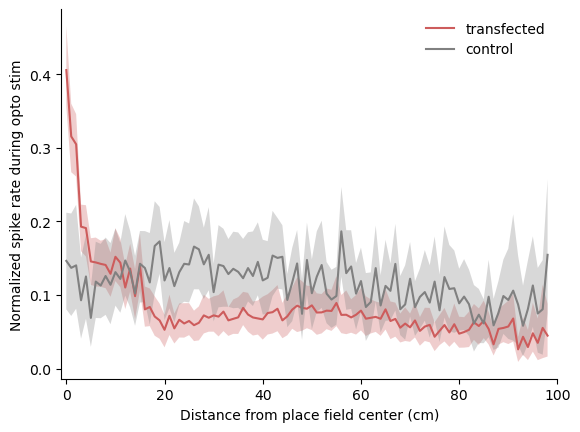

In [14]:
from ms_stim_analysis.Analysis.utils import bootstrap_traces
from ms_stim_analysis.Style.style_guide import animal_style

distance_bins = np.arange(0, 100, 1)
fig = plt.figure()
ax = fig.add_subplot(111)
for animal, all_results in animal_results.items():
    curves = []
    for result in all_results.values():
        bin_avg = []
        for i, bin_start in enumerate(distance_bins[:-1]):
            bin_end = distance_bins[i + 1]
            ind = np.where(
                (bin_start <= result["distances"]) & (result["distances"] < bin_end)
            )[0]
            if len(ind) == 0:
                bin_avg.append(np.nan)
            else:
                bin_avg.append(np.mean(result["spike_counts"][ind]))
            # bin_avg.append(np.mean([x for x,d in zip(result["spike_counts"],result["distances"]) if bin_start<=d<bin_end]))
        # plt.plot(distance_bins, bin_avg / np.nanmax(bin_avg))
        curves.append(bin_avg / np.nanmax(bin_avg))
        # curves.append(bin_avg / np.mean(result["spike_counts"]))
    curves = np.array(curves)
    yy, rng = bootstrap_traces(curves, statistic=np.nanmean, n_boot=100)
    color = animal_style.loc[animal]["color"]
    plt.plot(distance_bins[:-1], yy, color=color, label=animal)
    plt.fill_between(
        distance_bins[:-1],
        *rng,
        facecolor=color,
        alpha=0.3,
    )
plt.xlabel("Distance from place field center (cm)")
plt.ylabel("Normalized spike rate during opto stim")
plt.legend(frameon=False)
ax.spines[["top", "right"]].set_visible(False)
plt.xlim([-1, 100])
plt.rcParams["svg.fonttype"] = "none"
fig.savefig("../Figures/Fig_S2/Fig_S2b_stim_field_interaction.svg")